In [1]:
library(ggplot2)
library(igraph)
library(dplyr)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘dplyr’


The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Generate a scale free network
N <- 1e5
m <- 2
# g <- barabasi.game(N, m, directed = FALSE)
# g <- sample_pa(N, power=2, m, directed = FALSE)
g <- erdos.renyi.game(N, 0.0002, directed = FALSE)
print(paste("Mean degree", mean(degree(g))))

# Assign the critical threshold to each node
V(g)$z_c <- degree(g)

# Assign the initial state to each node
V(g)$z <- 0

[1] "Mean degree 20.05552"


Note that you can implement the toppling using either recursion or iteration. Recursion might be more elegant, but depth limit can be a constraint.

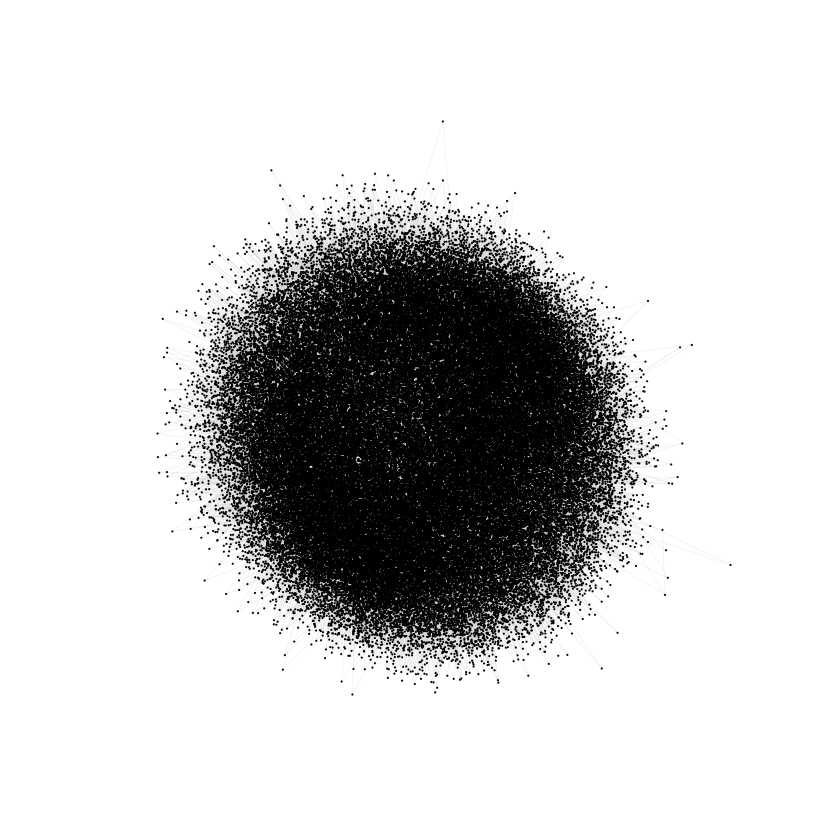

In [56]:
plot(g,
     vertex.size = 0.1,
     vertex.label = NA,
     vertex.color = "lightblue",
     edge.width = 0.2,
     edge.color = "lightgray",
     layout = layout_with_fr(g, niter = 500))

In [54]:
# Calculate degrees
degree_values <- degree(g)

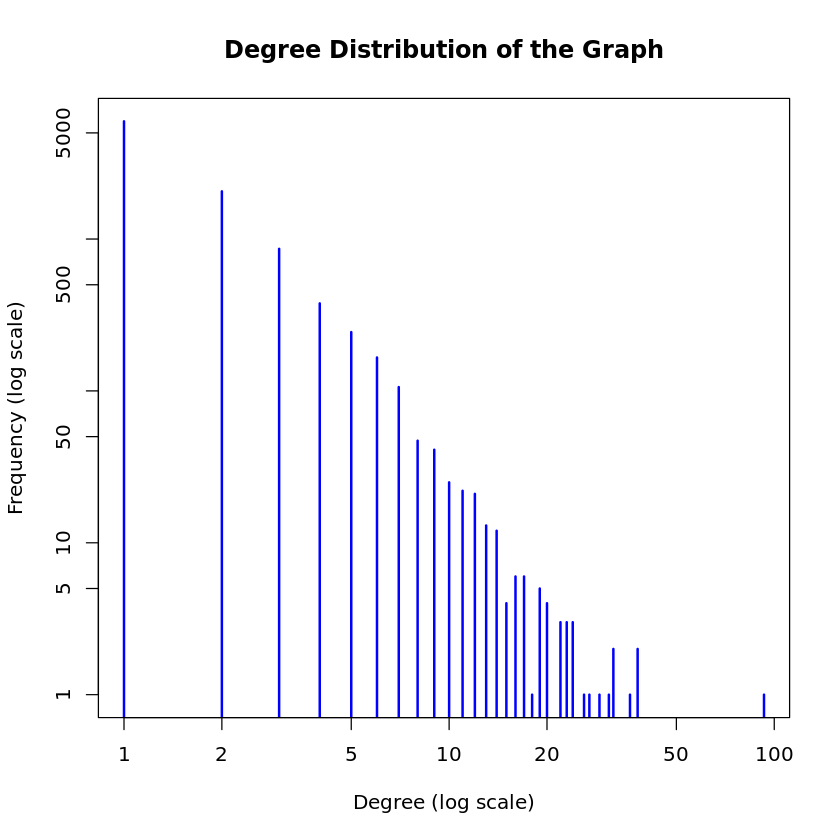

In [48]:
# Plot degree distribution


# Calculate the degree distribution
degree_distribution <- table(degree_values)

# Plot the degree distribution
plot(as.numeric(names(degree_distribution)), as.numeric(degree_distribution),
     log = "xy", type = "h",
     xlab = "Degree (log scale)", ylab = "Frequency (log scale)",
     main = "Degree Distribution of the Graph",
     col = "blue", lwd = 2)

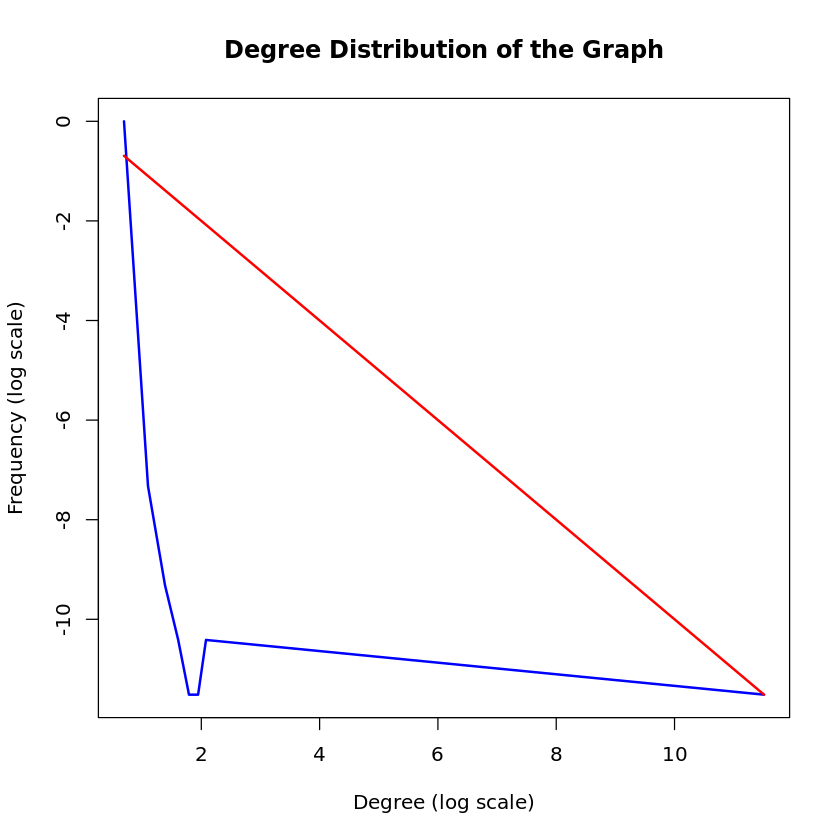

In [55]:
data <- as.data.frame(degree_values)
data <- data %>% group_by(degree_values) %>% summarise(n = n() / N)

plot(log(data$degree_values), log(data$n), type = "l", col = "blue", lwd = 2,
     xlab = "Degree (log scale)", ylab = "Frequency (log scale)",
     main = "Degree Distribution of the Graph")
x <- log(data$degree_values)
lines(x, -1*x, col = "red", lwd = 2)

In [58]:
## Dynamic ##

f <- 1 / N

iter <- 4e4
pb <- txtProgressBar(min = 0, max = iter, style = 3)

data <- data.frame()
for (i in 1:iter){ # Shold be a stopping condition
  unstable_queue <- c()

  # Sample a node
  node <- sample(N, 1)

  # Update the state of the node
  V(g)[node]$z <- V(g)[node]$z + 1

  # Check if the node has become unstable
  if (V(g)[node]$z >= V(g)[node]$z_c){
    unstable_queue <- c(node)
  }

  # Solve unstable queue
  S <- c() # Avalanche size
  T <- 1 # Avalanche duration
  G <- 0 # Toppled grains
  while (length(unstable_queue) > 0) {
    # Pick the first node in the queue
    node <- unstable_queue[1]
    S <- c(S, node)
    
    # Remove the node from the queue
    unstable_queue <- unstable_queue[-1]

    # Get the neighbors of the node
    neighbors <- neighbors(g, node)
    
    # Sample a fraction of the neighbors
    to_keep <- runif(length(neighbors)) < 1 - f
    neighbors <- neighbors[to_keep]
    G <- G + length(neighbors)
    
    # Update the state of the neighbors
    V(g)[neighbors]$z <- V(g)[neighbors]$z + 1

    # Update the state of the node
    V(g)[node]$z <- 0

    # Check if the neighbors have become unstable
    unstable_neighbors <- neighbors[V(g)[neighbors]$z >= V(g)[neighbors]$z_c]
    if (length(unstable_neighbors) > 0) {
      # Add the unstable neighbors to the queue
      unstable_queue <- unique(c(unstable_queue, unstable_neighbors))

      # Update duration when new nodes are added to the queue
      T <- T + 1
    }

  } # End of while loop

  A <- unique(S)
  if (length(S) > 0){
    # Save the avalanche size
    data <- rbind(data, data.frame(S = length(S), A = length(A), T = T, G = G))
  }

  setTxtProgressBar(pb, i)

} # End of for loop

close(pb)

  |                                                                      |   0%

  |======================================================================| 100%


In [59]:
area <- data |>
  group_by(A) |>
  summarise(F = n() / nrow(data))

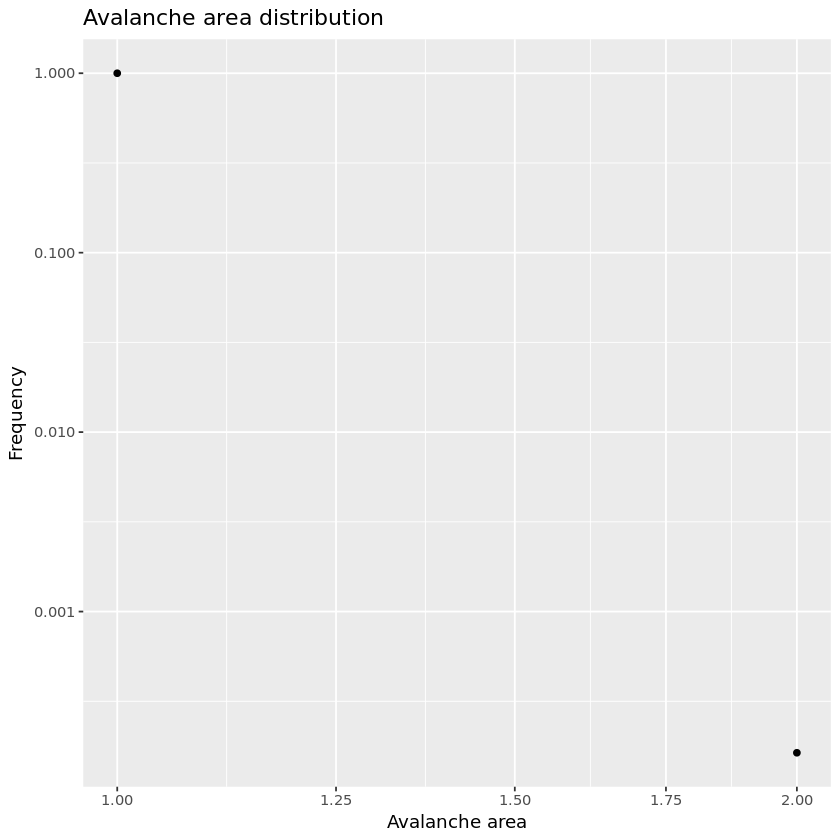

In [60]:
ggplot(area, aes(x = A, y = F)) +
  geom_point() +
  scale_x_log10() +
  scale_y_log10() +
  labs(title = "Avalanche area distribution",
       x = "Avalanche area",
       y = "Frequency")

In [ ]:
func <- function(x, tau, s_c){
  x^(-tau) * exp(-x/s_c)
}

area2 <- area |>
  filter(A < 50)

fit <- nls(F ~ func(A, tau, s_c), data = area2, start = list(tau = 1.5, s_c = 1e3))
summary(fit)

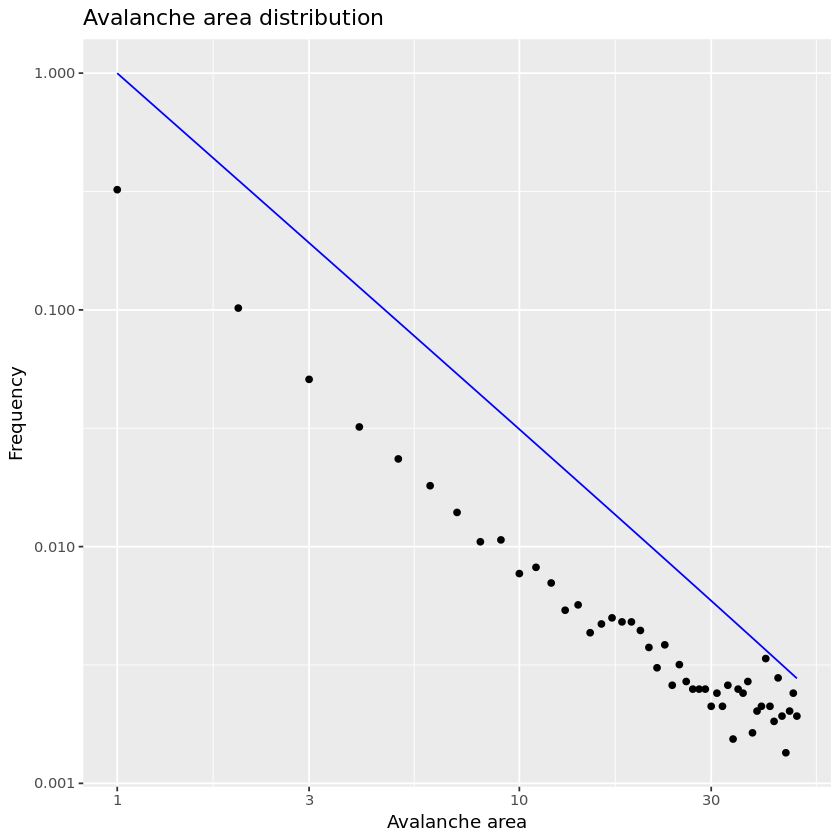

In [52]:
# Plot the fit
ggplot(area2, aes(x = A, y = F)) +
  geom_point() +
  # geom_line(aes(y = predict(fit)), color = "red") +
  geom_line(aes(y=func(A, 1.5, 1e3)), color = "blue") +
  scale_x_log10() +
  scale_y_log10() +
  labs(title = "Avalanche area distribution",
       x = "Avalanche area",
       y = "Frequency")

In [53]:
area3

A,F
<int>,<dbl>
1,0.321888825
2,0.101750337
3,0.050875168
5,0.023466051
8,0.010482785
13,0.005385651
22,0.003077515
36,0.002404309


In [54]:
# Linear fit of the log-log plot
log_intervals <- round(10^seq(log10(1), log10(100), length.out = 10))
print(log_intervals)
area3 <- area2[area2$A %in% log_intervals,]

fit2 <- lm(log(F) ~ log(A), data = area3)
summary(fit2)

 [1]   1   2   3   5   8  13  22  36  60 100



Call:
lm(formula = log(F) ~ log(A), data = area3)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.2510 -0.1402 -0.0522  0.1026  0.4052 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.36413    0.16264  -8.388 0.000156 ***
log(A)      -1.41523    0.07504 -18.859 1.44e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2431 on 6 degrees of freedom
Multiple R-squared:  0.9834,	Adjusted R-squared:  0.9806 
F-statistic: 355.7 on 1 and 6 DF,  p-value: 1.436e-06


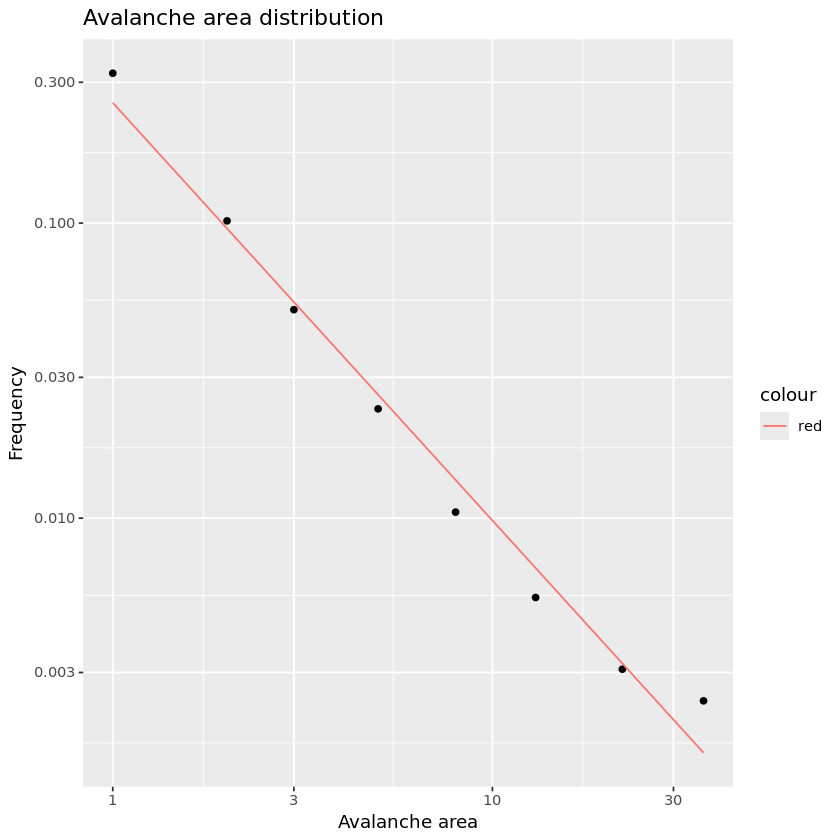

In [55]:
# Plot the fit
ggplot(area3, aes(x = A, y = F)) +
  geom_point() +
  geom_line(aes(y = exp(predict(fit2)), color = "red")) +
  scale_x_log10() +
  scale_y_log10() +
  labs(title = "Avalanche area distribution",
       x = "Avalanche area",
       y = "Frequency")


Call:
lm(formula = log(T) ~ log(A), data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.74796 -0.05482  0.03027  0.05436  0.76423 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0302714  0.0019163   -15.8   <2e-16 ***
log(A)       0.9142210  0.0006344  1441.0   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1364 on 10396 degrees of freedom
Multiple R-squared:  0.995,	Adjusted R-squared:  0.995 
F-statistic: 2.077e+06 on 1 and 10396 DF,  p-value: < 2.2e-16


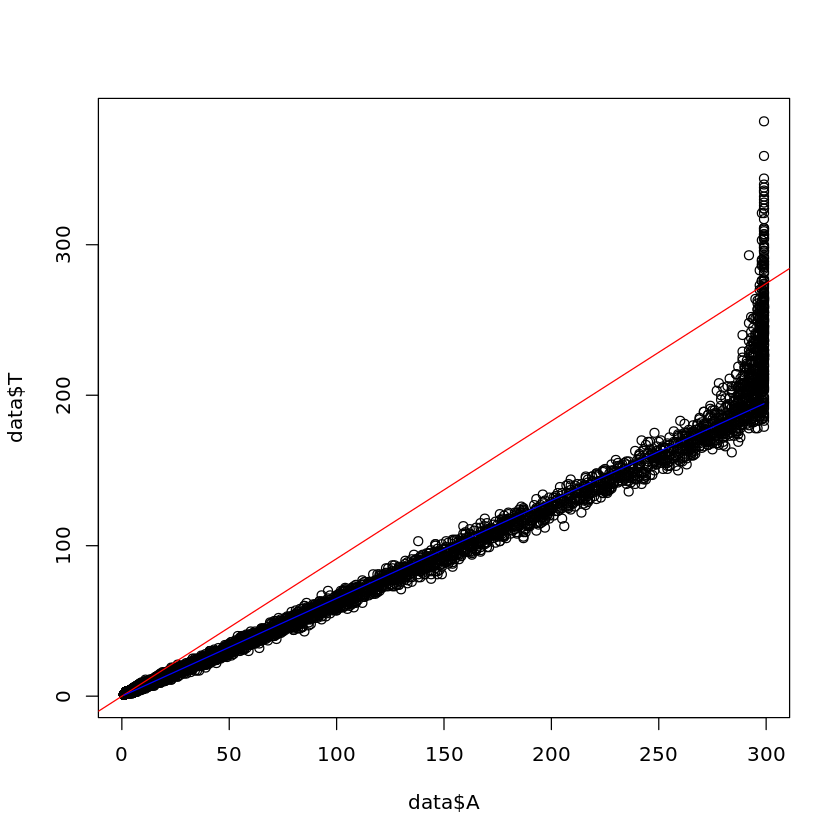

In [70]:
# Linear fit of T
fit <- lm(log(T) ~ log(A), data = data)
summary(fit)

plot(data$A, data$T)
abline(fit, col = "red")
lines(data$A, 0.65*data$A, col = "blue")

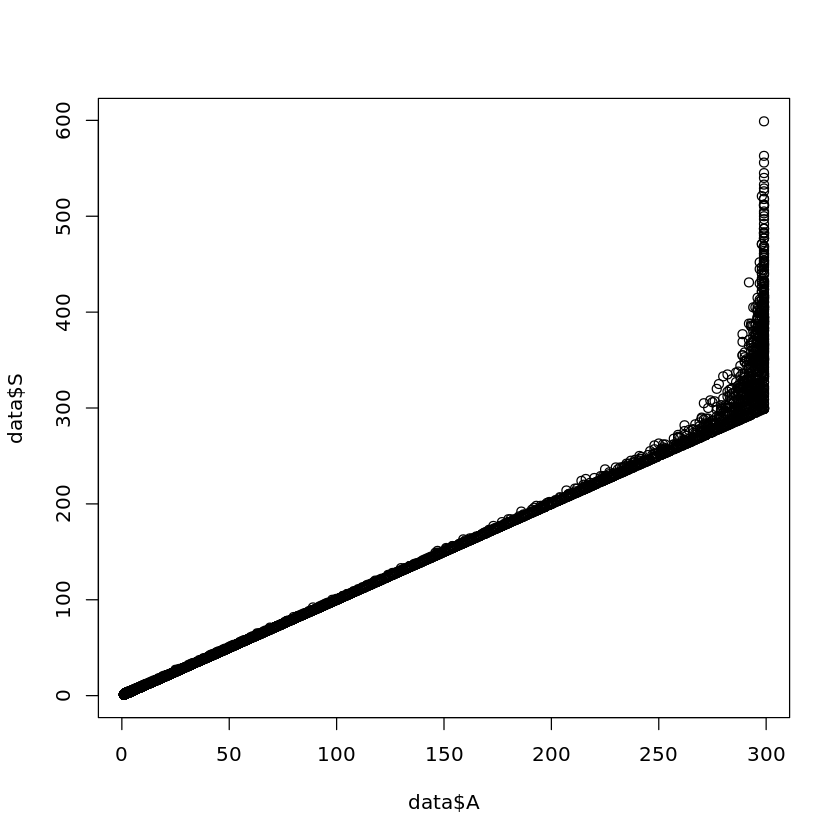

In [71]:
plot(data$A, data$S)